In [3]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from datetime import datetime
from sklearn.model_selection import train_test_split
from catboost import CatBoostClassifier
from sklearn.metrics import classification_report,confusion_matrix, roc_auc_score, log_loss, accuracy_score

In [4]:
from datasets import load_dataset

/home/santoshkumarguntupalli/miniconda3/envs/myenv/lib/python3.11/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [5]:
dataset = load_dataset("dazzle-nu/CIS435-CreditCardFraudDetection")

Generating train split: 100%|██████████| 1048575/1048575 [00:07<00:00, 134337.72 examples/s]


In [6]:
df=dataset['train'].to_pandas()

In [7]:
df.columns

Index(['Unnamed: 0', 'trans_date_trans_time', 'cc_num', 'merchant', 'category',
       'amt', 'first', 'last', 'gender', 'street', 'city', 'state', 'zip',
       'lat', 'long', 'city_pop', 'job', 'dob', 'trans_num', 'unix_time',
       'merch_lat', 'merch_long', 'is_fraud', 'Unnamed: 23', '6006'],
      dtype='object')

In [8]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1048575 entries, 0 to 1048574
Data columns (total 25 columns):
 #   Column                 Non-Null Count    Dtype  
---  ------                 --------------    -----  
 0   Unnamed: 0             1048575 non-null  int64  
 1   trans_date_trans_time  1048575 non-null  object 
 2   cc_num                 1048575 non-null  float64
 3   merchant               1048575 non-null  object 
 4   category               1048575 non-null  object 
 5   amt                    1048575 non-null  float64
 6   first                  1048575 non-null  object 
 7   last                   1048575 non-null  object 
 8   gender                 1048575 non-null  object 
 9   street                 1048575 non-null  object 
 10  city                   1048575 non-null  object 
 11  state                  1048575 non-null  object 
 12  zip                    1048575 non-null  int64  
 13  lat                    1048575 non-null  float64
 14  long              

In [9]:
df = df.drop(columns=['Unnamed: 0','Unnamed: 23', '6006'], axis=1)
df.head()

,trans_date_trans_time,cc_num,merchant,category,amt,first,last,gender,street,city,...,lat,long,city_pop,job,dob,trans_num,unix_time,merch_lat,merch_long,is_fraud
0,1/1/19 0:00,2.703190e+15,"fraud_Rippin, Kub and Mann",misc_net,4.97,Jennifer,Banks,F,561 Perry Cove,Moravian Falls,...,36.0788,-81.1781,3495,"Psychologist, counselling",3/9/88,0b242abb623afc578575680df30655b9,1325376018,36.011293,-82.048315,0
1,1/1/19 0:00,6.304230e+11,"fraud_Heller, Gutmann and Zieme",grocery_pos,107.23,Stephanie,Gill,F,43039 Riley Greens Suite 393,Orient,...,48.8878,-118.2105,149,Special educational needs teacher,6/21/78,1f76529f8574734946361c461b024d99,1325376044,49.159047,-118.186462,0
2,1/1/19 0:00,3.885950e+13,fraud_Lind-Buckridge,entertainment,220.11,Edward,Sanchez,M,594 White Dale Suite 530,Malad City,...,42.1808,-112.2620,4154,Nature conservation officer,1/19/62,a1a22d70485983eac12b5b88dad1cf95,1325376051,43.150704,-112.154481,0
3,1/1/19 0:01,3.534090e+15,"fraud_Kutch, Hermiston and Farrell",gas_transport,45.00,Jeremy,White,M,9443 Cynthia Court Apt. 038,Boulder,...,46.2306,-112.1138,1939,Patent attorney,1/12/67,6b849c168bdad6f867558c3793159a81,1325376076,47.034331,-112.561071,0
4,1/1/19 0:03,3.755340e+14,fraud_Keeling-Crist,misc_pos,41.96,Tyler,Garcia,M,408 Bradley Rest,Doe Hill,...,38.4207,-79.4629,99,Dance movement psychotherapist,3/28/86,a41d7549acf90789359a9aa5346dcb46,1325376186,38.674999,-78.632459,0


In [10]:
df['cc_num']=df['cc_num'].astype('Int64').astype(str)


In [11]:
# Step 1: Ensure datetime types
df['trans_date_trans_time'] = pd.to_datetime(df['trans_date_trans_time'])
df['dob'] = pd.to_datetime(df['dob'], errors='coerce')

# Step 2: Extract years
trans_year = df['trans_date_trans_time'].dt.year
dob_year = df['dob'].dt.year

# Step 3: Find where dob year > transaction year
mask = dob_year > trans_year

# Step 4: Fix those dates by subtracting 100 years
df.loc[mask, 'dob'] = df.loc[mask, 'dob'] - pd.DateOffset(years=100)


/tmp/ipykernel_47437/1713297421.py:2: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  df['trans_date_trans_time'] = pd.to_datetime(df['trans_date_trans_time'])
/tmp/ipykernel_47437/1713297421.py:3: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  df['dob'] = pd.to_datetime(df['dob'], errors='coerce')


In [12]:
df[["trans_date_trans_time", 'dob']]

,trans_date_trans_time,dob
0,2019-01-01 00:00:00,1988-03-09
1,2019-01-01 00:00:00,1978-06-21
2,2019-01-01 00:00:00,1962-01-19
3,2019-01-01 00:01:00,1967-01-12
4,2019-01-01 00:03:00,1986-03-28
...,...,...
1048570,2020-03-10 16:07:00,1943-05-28
1048571,2020-03-10 16:07:00,1999-06-28
1048572,2020-03-10 16:08:00,1952-04-02
1048573,2020-03-10 16:08:00,1990-06-25


In [13]:
df.duplicated().any()

np.False_

In [14]:
fraud_counts = df['is_fraud'].value_counts()
fraud_percent = df['is_fraud'].value_counts(normalize=True) * 100
print(fraud_counts)
print(fraud_percent)

is_fraud
0    1042569
1       6006
Name: count, dtype: int64
is_fraud
0    99.427223
1     0.572777
Name: proportion, dtype: float64


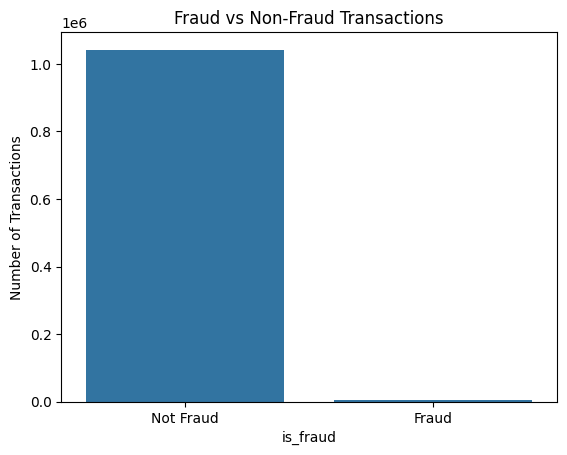

In [15]:
sns.countplot(x='is_fraud', data=df)
plt.title('Fraud vs Non-Fraud Transactions')
plt.xticks([0, 1], ['Not Fraud', 'Fraud'])
plt.ylabel('Number of Transactions')
plt.show()

<Figure size 1000x500 with 0 Axes>

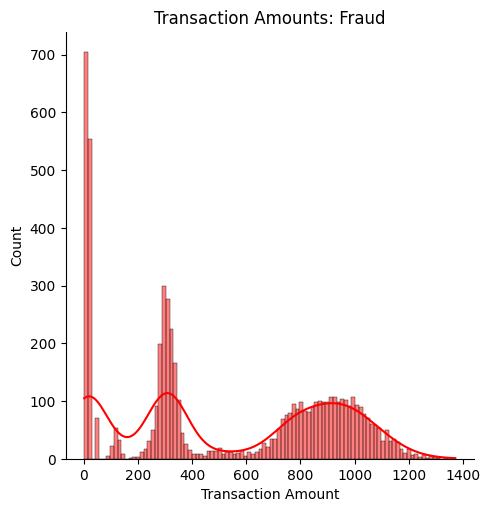

In [16]:
plt.figure(figsize=(10, 5))
sns.displot(df[df['is_fraud'] == 1]['amt'], bins=100, color='red', label='Fraud', kde=True)
plt.title('Transaction Amounts: Fraud')
plt.xlabel('Transaction Amount')
plt.show()


In [17]:
df["category"].value_counts()

category
gas_transport     106430
grocery_pos        99906
home               99578
shopping_pos       94353
kids_pets          91404
shopping_net       78899
entertainment      75981
food_dining        74041
personal_care      73498
health_fitness     69362
misc_pos           64492
misc_net           51082
grocery_net        36719
travel             32830
Name: count, dtype: int64

<Axes: ylabel='amt'>

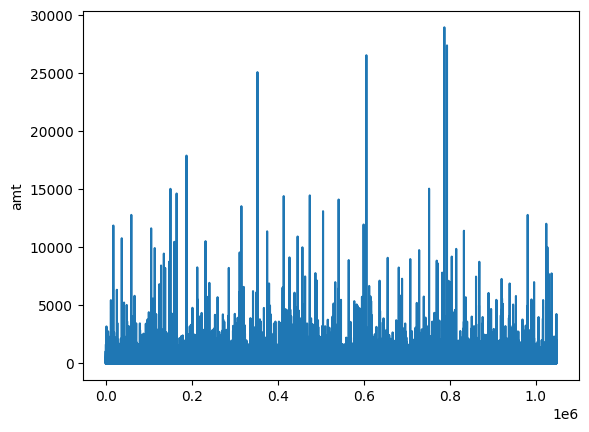

In [31]:
sns.lineplot(df["amt"])

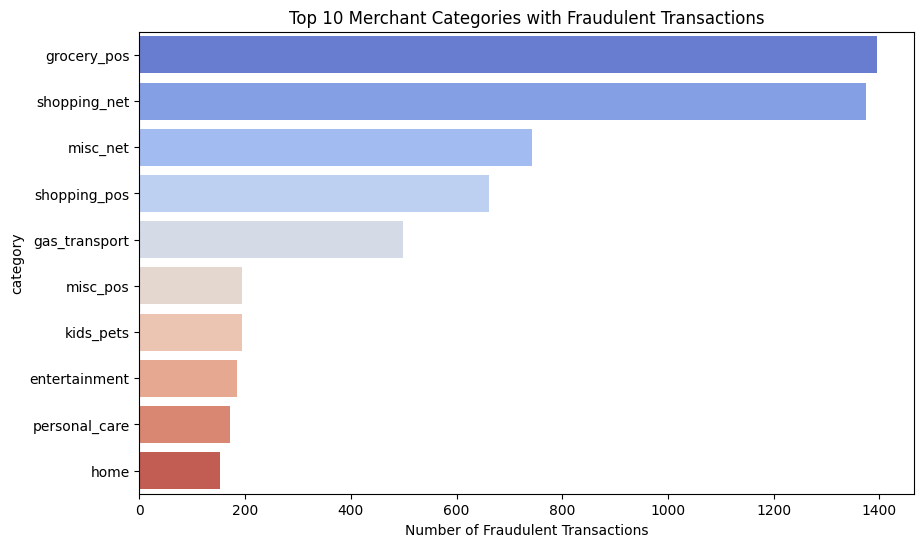

In [17]:
fraud_by_category = df[df['is_fraud'] == 1]['category'].value_counts().head(10)

plt.figure(figsize=(10, 6))
sns.barplot(x=fraud_by_category.values, y=fraud_by_category.index, palette='coolwarm', hue=fraud_by_category.index)
plt.title('Top 10 Merchant Categories with Fraudulent Transactions')
plt.xlabel('Number of Fraudulent Transactions')
plt.show()


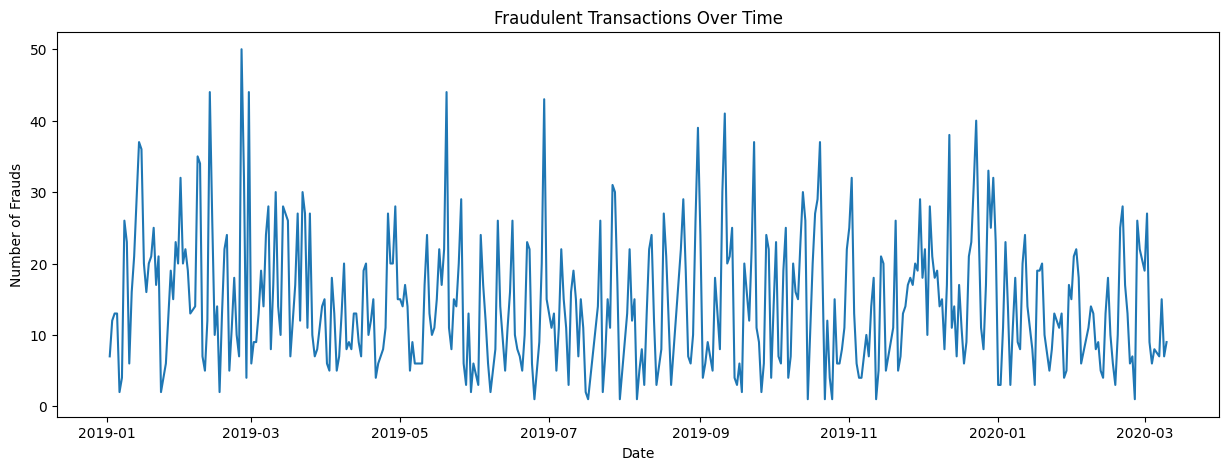

In [18]:
# Create a new column for the date only
df['date'] = df['trans_date_trans_time'].dt.date

# Plot number of frauds per day
fraud_per_day = df[df['is_fraud'] == 1].groupby('date').size()

plt.figure(figsize=(15, 5))
fraud_per_day.plot()
plt.title('Fraudulent Transactions Over Time')
plt.xlabel('Date')
plt.ylabel('Number of Frauds')
plt.show()


In [19]:
import folium
from folium.plugins import HeatMap

In [20]:
# Filter fraudulent transactions
fraud_df = df[df['is_fraud'] == 1]

# Create a base map
fraud_map = folium.Map(location=[fraud_df['lat'].mean(), fraud_df['long'].mean()], zoom_start=5)

# Add heatmap layer
heat_data = list(zip(fraud_df['lat'], fraud_df['long']))

heat_map_location = HeatMap(heat_data).add_to(fraud_map)

fraud_map.save('fraud_heatmap.html')

<Axes: xlabel='count', ylabel='city'>

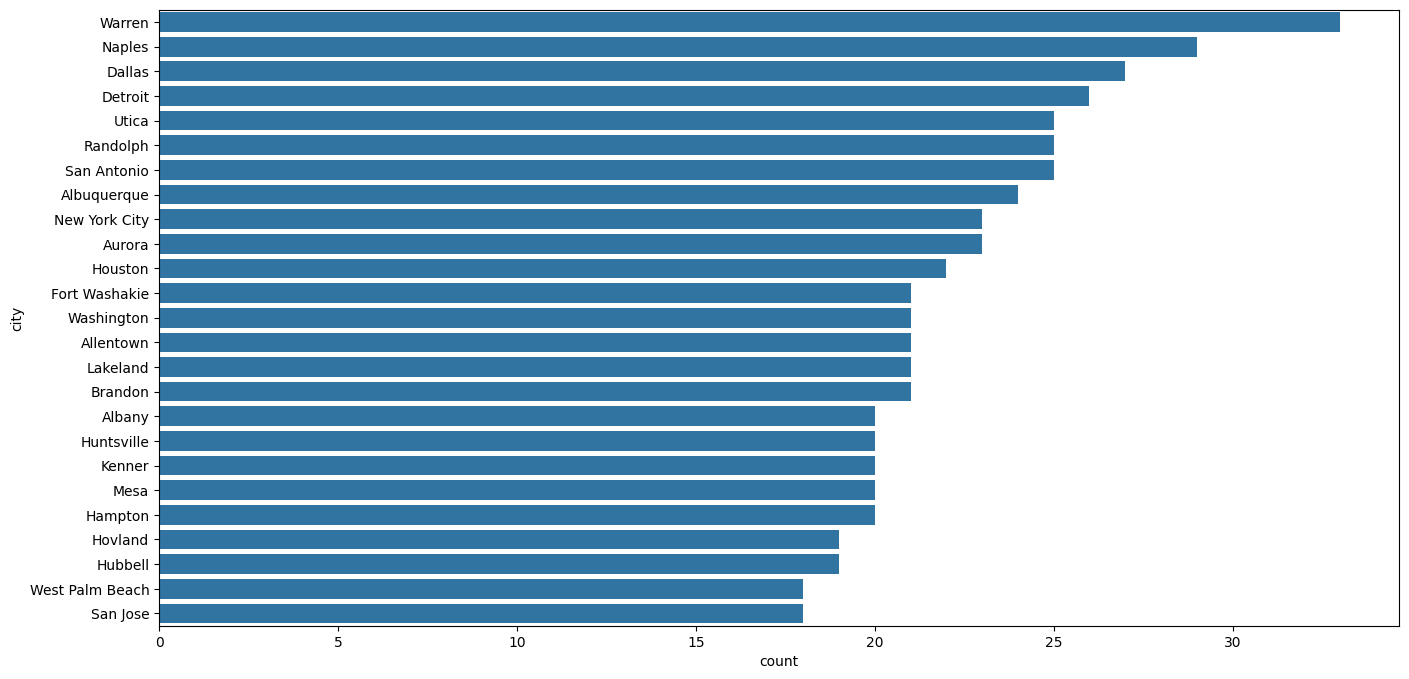

In [21]:
# Find top cities with most fraud
plt.figure(figsize=(16,8))
top_cities = df[df['is_fraud'] == 1]['city'].value_counts().head(25)
sns.barplot(top_cities, orient='h')

<Axes: xlabel='state', ylabel='count'>

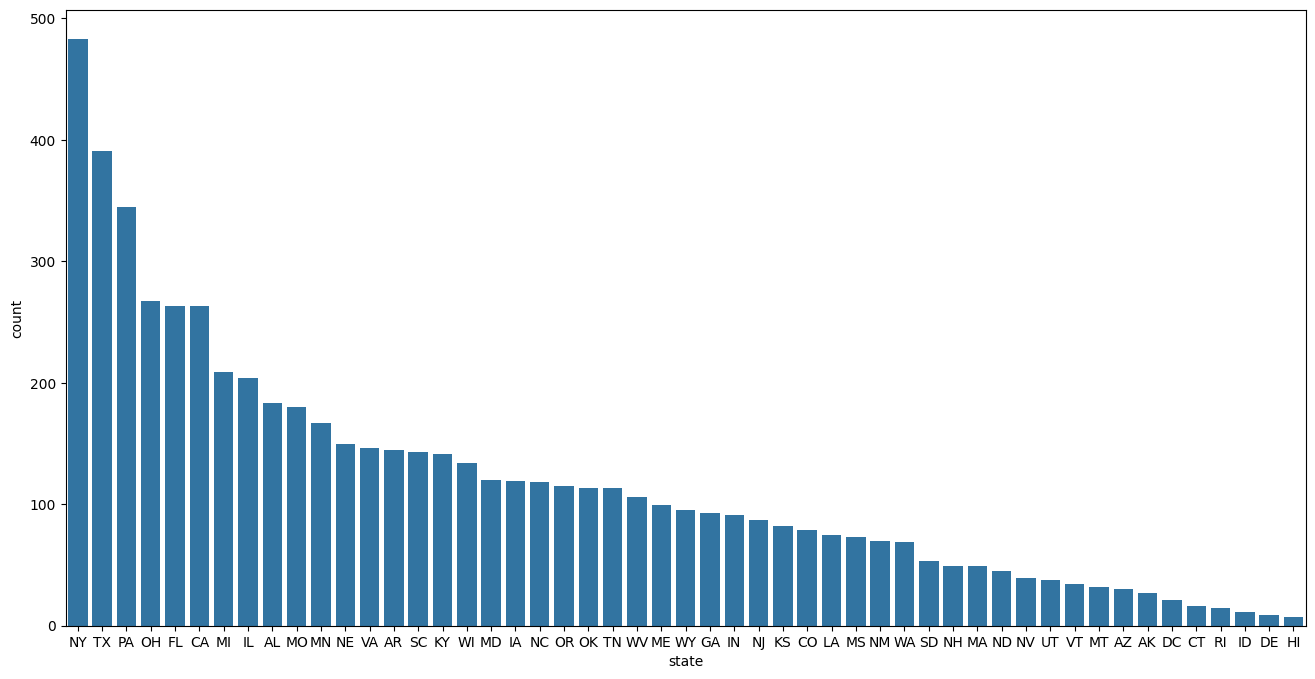

In [22]:
# Find top states with most fraud
plt.figure(figsize=(16,8))
top_states = df[df['is_fraud'] == 1]['state'].value_counts()
sns.barplot(top_states)


In [23]:
# Extract hour, day, weekday
df['hour'] = df['trans_date_trans_time'].dt.hour
df['day'] = df['trans_date_trans_time'].dt.day
df['weekday'] = df['trans_date_trans_time'].dt.weekday
df['age'] = (df['trans_date_trans_time'] - df['dob']).dt.days // 365
df['is_large_transaction'] = (df['amt'] > 200).astype(int)
df['log_amt'] = np.log1p(df['amt'])

In [24]:
from geopy.distance import geodesic

# Function to calculate distance
def haversine_distance(row):
    cust_loc = (row['lat'], row['long'])
    merch_loc = (row['merch_lat'], row['merch_long'])
    return geodesic(cust_loc, merch_loc).km

# Apply function
df['distance_km'] = df.apply(haversine_distance, axis=1)


In [25]:
df.columns

Index(['trans_date_trans_time', 'cc_num', 'merchant', 'category', 'amt',
       'first', 'last', 'gender', 'street', 'city', 'state', 'zip', 'lat',
       'long', 'city_pop', 'job', 'dob', 'trans_num', 'unix_time', 'merch_lat',
       'merch_long', 'is_fraud', 'date', 'hour', 'day', 'weekday', 'age',
       'is_large_transaction', 'log_amt', 'distance_km'],
      dtype='object')

In [26]:
df_cleaned=df[['date', 'hour', 'day', 'weekday', 'age', 'category', 'is_large_transaction', 'log_amt', 'lat', 'long', 'merch_lat',
               'merch_long','distance_km', 'gender', 'job', 'city_pop', 'is_fraud']]

df_cleaned['date'] = pd.to_datetime(df['date'])
df_cleaned['gender'] = df_cleaned['gender'].map({'M': 0, 'F': 1})


df_cleaned.set_index("date")

C:\Users\lenovo\AppData\Local\Temp\ipykernel_6076\299478472.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_cleaned['date'] = pd.to_datetime(df['date'])
C:\Users\lenovo\AppData\Local\Temp\ipykernel_6076\299478472.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_cleaned['gender'] = df_cleaned['gender'].map({'M': 0, 'F': 1})


,hour,day,weekday,age,category,is_large_transaction,log_amt,lat,long,merch_lat,merch_long,distance_km,gender,job,city_pop,is_fraud
date,,,,,,,,,,,,,,,,
2019-01-01,0,1,1,30,misc_net,0,1.786747,36.0788,-81.1781,36.011293,-82.048315,78.773821,1,"Psychologist, counselling",3495,0
2019-01-01,0,1,1,40,grocery_pos,0,4.684259,48.8878,-118.2105,49.159047,-118.186462,30.216618,1,Special educational needs teacher,149,0
2019-01-01,0,1,1,56,entertainment,1,5.398660,42.1808,-112.2620,43.150704,-112.154481,108.102912,0,Nature conservation officer,4154,0
2019-01-01,0,1,1,52,gas_transport,0,3.828641,46.2306,-112.1138,47.034331,-112.561071,95.685115,0,Patent attorney,1939,0
2019-01-01,0,1,1,32,misc_pos,0,3.760269,38.4207,-79.4629,38.674999,-78.632459,77.702395,0,Dance movement psychotherapist,99,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2020-03-10,16,10,1,76,health_fitness,0,4.356709,39.0305,-76.5515,38.779464,-76.317042,34.500094,1,"Accountant, chartered certified",92106,0
2020-03-10,16,10,1,20,misc_pos,0,4.770176,41.1826,-92.3097,41.400318,-92.726724,42.483526,1,Geochemist,1583,0
2020-03-10,16,10,1,67,home,0,3.103240,38.2507,-85.7476,37.293339,-84.798122,135.234322,1,Engineering geologist,736284,0


In [27]:
df_cleaned.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1048575 entries, 0 to 1048574
Data columns (total 17 columns):
 #   Column                Non-Null Count    Dtype         
---  ------                --------------    -----         
 0   date                  1048575 non-null  datetime64[ns]
 1   hour                  1048575 non-null  int32         
 2   day                   1048575 non-null  int32         
 3   weekday               1048575 non-null  int32         
 4   age                   1048575 non-null  int64         
 5   category              1048575 non-null  object        
 6   is_large_transaction  1048575 non-null  int32         
 7   log_amt               1048575 non-null  float64       
 8   lat                   1048575 non-null  float64       
 9   long                  1048575 non-null  float64       
 10  merch_lat             1048575 non-null  float64       
 11  merch_long            1048575 non-null  float64       
 12  distance_km           1048575 non-null  fl

In [28]:
X= df_cleaned.drop(columns= "is_fraud", axis=1)
y= df_cleaned["is_fraud"]

In [29]:
X_train, X_val, y_train, y_val = train_test_split(X,y, test_size=0.25, random_state=5959)

In [30]:
X_train

,date,hour,day,weekday,age,category,is_large_transaction,log_amt,lat,long,merch_lat,merch_long,distance_km,gender,job,city_pop
895535,2019-12-25,17,25,2,53,kids_pets,0,4.133565,38.6865,-121.3494,38.127032,-121.554927,64.645786,0,Soil scientist,757530
103847,2019-03-01,19,1,4,64,personal_care,0,3.678071,38.2427,-122.9145,38.388571,-123.142030,25.654124,1,Occupational psychologist,337
305147,2019-05-27,22,27,0,43,health_fitness,0,3.204371,44.8755,-88.1555,45.672610,-88.543131,93.664739,0,Mining engineer,5548
8260,2019-01-06,8,6,6,52,shopping_pos,0,2.131797,40.6284,-76.1950,41.014506,-75.213197,93.266083,1,Ecologist,1606
463123,2019-07-23,4,23,1,53,shopping_net,0,1.985131,44.6255,-116.4493,43.867187,-115.939767,93.574830,0,Cartographer,129
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
745092,2019-11-15,2,15,4,44,misc_pos,0,3.678324,32.8088,-83.1740,33.517046,-82.508889,100.095822,0,Film/video editor,1841
442320,2019-07-15,19,15,0,91,home,0,4.145038,37.7773,-119.0825,37.845183,-118.982640,11.579841,0,Health service manager,633
1007303,2020-02-17,21,17,0,21,grocery_pos,0,4.678699,41.4802,-86.6919,40.539775,-85.928184,122.615196,1,"Psychologist, forensic",1423
457522,2019-07-21,16,21,6,34,shopping_pos,0,0.904218,35.8985,-97.2607,35.353079,-97.258461,60.515935,1,Amenity horticulturist,1493


In [31]:
cat_cols=df_cleaned.select_dtypes(include="object").columns
cat_cols

Index(['category', 'job'], dtype='object')

In [32]:
model = CatBoostClassifier(
    cat_features=cat_cols.values,
    eval_metric='Recall'
)

In [33]:
model.fit(X_train,y_train)

Learning rate set to 0.177575
0:	learn: 0.3242762	total: 894ms	remaining: 14m 52s
1:	learn: 0.3240535	total: 1.6s	remaining: 13m 16s
2:	learn: 0.3242762	total: 2.34s	remaining: 12m 58s
3:	learn: 0.5233853	total: 3.01s	remaining: 12m 28s
4:	learn: 0.5048998	total: 3.74s	remaining: 12m 23s
5:	learn: 0.5608018	total: 4.34s	remaining: 11m 58s
6:	learn: 0.5714922	total: 5.02s	remaining: 11m 52s
7:	learn: 0.5587973	total: 5.65s	remaining: 11m 40s
8:	learn: 0.5982183	total: 6.27s	remaining: 11m 30s
9:	learn: 0.6289532	total: 6.91s	remaining: 11m 24s
10:	learn: 0.5984410	total: 7.68s	remaining: 11m 30s
11:	learn: 0.6106904	total: 8.51s	remaining: 11m 40s
12:	learn: 0.6552339	total: 9.3s	remaining: 11m 46s
13:	learn: 0.6726058	total: 10.1s	remaining: 11m 51s
14:	learn: 0.6797327	total: 11.2s	remaining: 12m 17s
15:	learn: 0.6904232	total: 12.3s	remaining: 12m 35s
16:	learn: 0.6951002	total: 13s	remaining: 12m 34s
17:	learn: 0.7140312	total: 14s	remaining: 12m 42s
18:	learn: 0.7178174	total: 15s	

In [34]:
importances = model.feature_importances_

In [35]:
feature_importances = pd.Series(importances, index=X_train.columns).sort_values(ascending=False)
print(feature_importances)

log_amt                 29.577345
category                14.630573
hour                    12.907306
age                     10.901740
date                     5.769249
city_pop                 4.938801
day                      3.878681
job                      2.420354
long                     2.211446
distance_km              2.147472
weekday                  2.035347
merch_lat                1.844041
merch_long               1.820324
gender                   1.772761
lat                      1.649096
is_large_transaction     1.495465
dtype: float64


<Axes: >

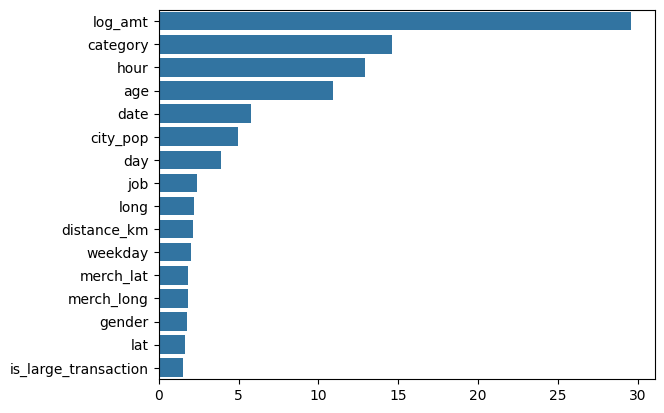

In [36]:
sns.barplot(feature_importances, orient="h")

In [37]:
y_pred=model.predict(X_val)
y_proba = model.predict_proba(X_val)[:, 1]

In [38]:
print("📋 Classification Report:")
print(classification_report(y_val, y_pred))

# 2. Confusion Matrix
print("🧾 Confusion Matrix:")
print(confusion_matrix(y_val, y_pred))

# 3. ROC AUC Score
roc_auc = roc_auc_score(y_val, y_proba)
print(f"📈 ROC AUC Score: {roc_auc:.4f}")

# 4. Accuracy Score
acc = accuracy_score(y_val, y_pred)
print(f"✅ Accuracy Score: {acc:.4f}")

# 5. Log Loss
ll = log_loss(y_val, y_proba)
print(f"🔻 Log Loss: {ll:.4f}")

📋 Classification Report:
              precision    recall  f1-score   support

           0       1.00      1.00      1.00    260628
           1       0.97      0.86      0.91      1516

    accuracy                           1.00    262144
   macro avg       0.98      0.93      0.96    262144
weighted avg       1.00      1.00      1.00    262144

🧾 Confusion Matrix:
[[260586     42]
 [   213   1303]]
📈 ROC AUC Score: 0.9992
✅ Accuracy Score: 0.9990
🔻 Log Loss: 0.0031


In [39]:
y_probs = model.predict(X_val, prediction_type="Probability")

In [40]:
threshold = 0.3
y_pred_custom = (y_probs[:, 1] >= threshold).astype(int)

In [41]:
print("📋 Classification Report:")
print(classification_report(y_val, y_pred_custom))

print("🧾 Confusion Matrix:")
print(confusion_matrix(y_val, y_pred_custom))

acc = accuracy_score(y_val, y_pred)
print(f"✅ Accuracy Score: {acc:.4f}")

📋 Classification Report:
              precision    recall  f1-score   support

           0       1.00      1.00      1.00    260628
           1       0.95      0.89      0.92      1516

    accuracy                           1.00    262144
   macro avg       0.97      0.94      0.96    262144
weighted avg       1.00      1.00      1.00    262144

🧾 Confusion Matrix:
[[260550     78]
 [   169   1347]]
✅ Accuracy Score: 0.9990


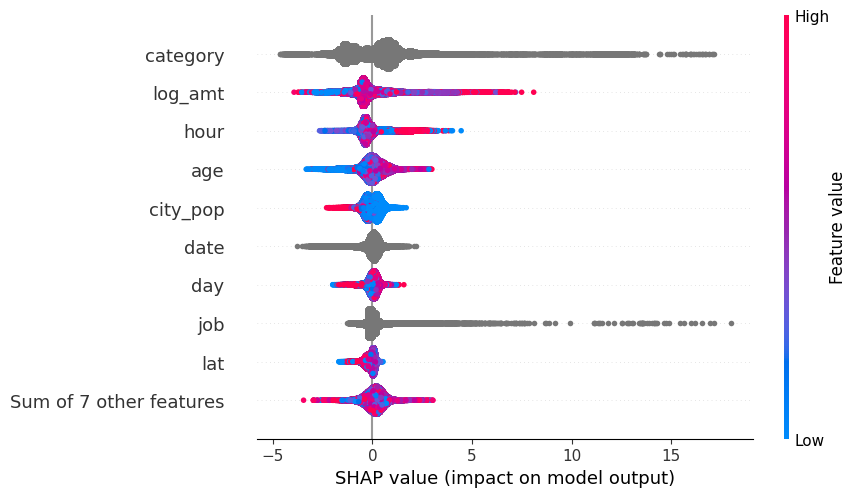

In [42]:
import shap
explainer = shap.Explainer(model)
shap_values = explainer(X_val)
shap.plots.beeswarm(shap_values)